# Лабораторная 1

In [11]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from scipy.stats import shapiro, kstest, norm

%matplotlib inline

In [12]:
df = pd.read_csv("StudentsPerformance.csv")
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 8 columns):
 #   Column                       Non-Null Count  Dtype 
---  ------                       --------------  ----- 
 0   gender                       1000 non-null   object
 1   race/ethnicity               1000 non-null   object
 2   parental level of education  1000 non-null   object
 3   lunch                        1000 non-null   object
 4   test preparation course      1000 non-null   object
 5   math score                   1000 non-null   int64 
 6   reading score                1000 non-null   int64 
 7   writing score                1000 non-null   int64 
dtypes: int64(3), object(5)
memory usage: 62.6+ KB


### Анализ пропусков

In [13]:
print(df.isnull().sum())

gender                         0
race/ethnicity                 0
parental level of education    0
lunch                          0
test preparation course        0
math score                     0
reading score                  0
writing score                  0
dtype: int64


Пропусков не обнаружено.

### Исследуем на выбросы, используя метод IQR и ящик с усами для визуализации

Выбросы в колонке math score:
     gender race/ethnicity parental level of education         lunch  \
17   female        group B            some high school  free/reduced   
59   female        group C            some high school  free/reduced   
145  female        group C                some college  free/reduced   
338  female        group B            some high school  free/reduced   
466  female        group D          associate's degree  free/reduced   
787  female        group B                some college      standard   
842  female        group B                 high school  free/reduced   
980  female        group B                 high school  free/reduced   

    test preparation course  math score  reading score  writing score  
17                     none          18             32             28  
59                     none           0             17             10  
145                    none          22             39             33  
338                    none      

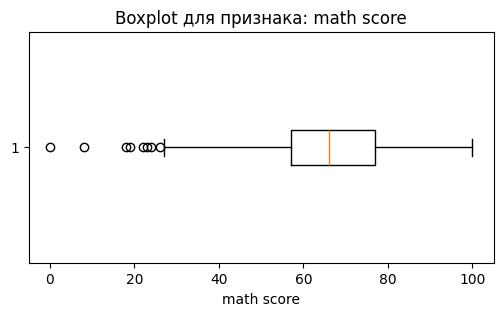

Выбросы в колонке reading score:
     gender race/ethnicity parental level of education         lunch  \
59   female        group C            some high school  free/reduced   
76     male        group E            some high school      standard   
211    male        group C                some college  free/reduced   
327    male        group A                some college  free/reduced   
596    male        group B                 high school  free/reduced   
980  female        group B                 high school  free/reduced   

    test preparation course  math score  reading score  writing score  
59                     none           0             17             10  
76                     none          30             26             22  
211                    none          35             28             27  
327                    none          28             23             19  
596                    none          30             24             15  
980                    none   

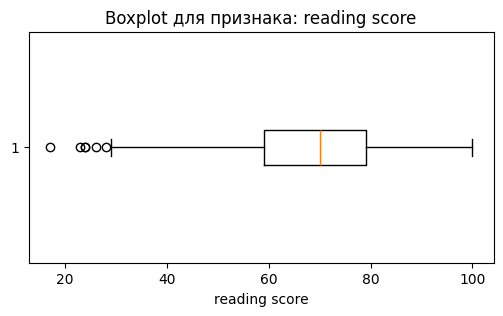

Выбросы в колонке writing score:
     gender race/ethnicity parental level of education         lunch  \
59   female        group C            some high school  free/reduced   
76     male        group E            some high school      standard   
327    male        group A                some college  free/reduced   
596    male        group B                 high school  free/reduced   
980  female        group B                 high school  free/reduced   

    test preparation course  math score  reading score  writing score  
59                     none           0             17             10  
76                     none          30             26             22  
327                    none          28             23             19  
596                    none          30             24             15  
980                    none           8             24             23  


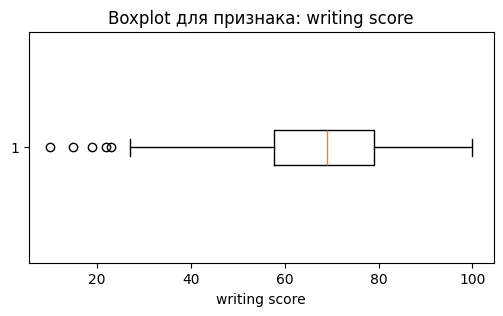

In [14]:
numeric_cols = df.select_dtypes(include='number').columns
for col in numeric_cols:
    q1 = df[col].quantile(0.25)
    q3 = df[col].quantile(0.75)
    iqr = q3 - q1
    lower_bound = q1 - 1.5 * iqr
    upper_bound = q3 + 1.5 * iqr
    outliers = df[(df[col] < lower_bound) | (df[col] > upper_bound)]
    print(f"Выбросы в колонке {col}:")
    print(outliers)

    plt.figure(figsize=(6, 3))
    plt.boxplot(df[col], vert=False)
    plt.title(f"Boxplot для признака: {col}")
    plt.xlabel(col)
    plt.show()

Метод IQR формально выявляет нижние выбросы (низкие оценки), однако они допустимы в контексте данных об успеваемости учащихся. Поэтому удаление или исправление таких значений не требуется.

### Проверка признаков на нормальный закон

- *Стандартизация данных*

    $z = \frac{x - \mu}{\sigma}$

In [ ]:
scaler = StandardScaler()
df_scaled = pd.DataFrame(scaler.fit_transform(df[numeric_cols]), columns=numeric_cols)
df_scaled.head()

,math score,reading score,writing score
0,0.390024,0.193999,0.391492
1,0.192076,1.427476,1.313269
2,1.577711,1.770109,1.642475
3,-1.259543,-0.833899,-1.583744
4,0.653954,0.605158,0.457333


- *Проверка признаков используя критерий Шапиро-Уилка и критерий Колмогорова-Смирнова*

    •	H0 (нулевая гипотеза): данные нормально распределены

	•	H1: данные не нормальны

,feature,sh_stat,sh_p,sh_test,ks_stat,ks_p,ks_test
0,math score,0.993151,0.000145,False,0.030763,0.294269,True
1,reading score,0.992921,0.000106,False,0.043912,0.041033,False
2,writing score,0.991964,0.000029,False,0.041582,0.061223,True


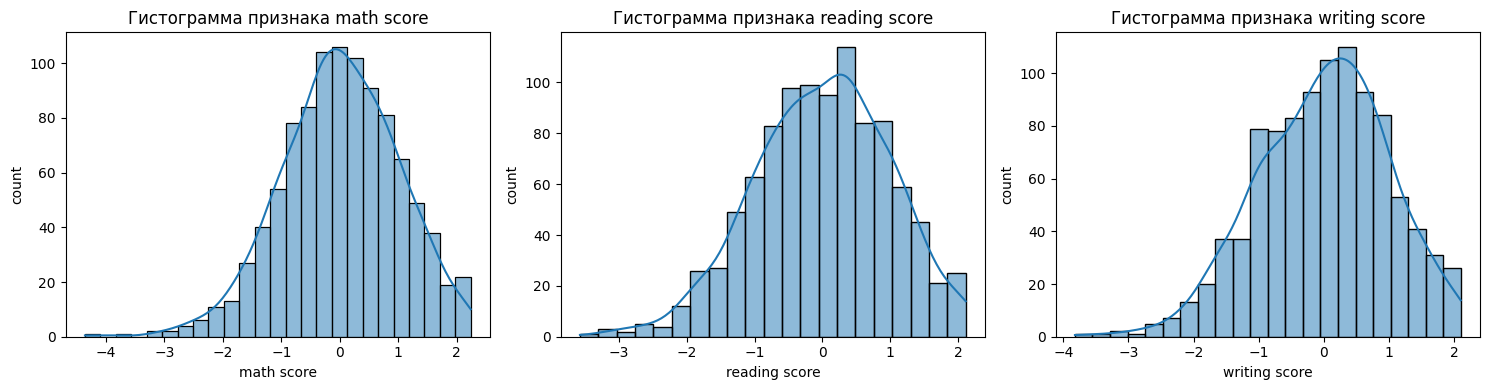

In [20]:
results = []
fig, axes = plt.subplots(1, 3, figsize=(15, 4))
for i in range(len(numeric_cols)):
    col = numeric_cols[i]
    sns.histplot(df_scaled[col], kde=True, ax=axes[i])
    axes[i].set_title(f"Гистограмма признака {col}")
    axes[i].set_xlabel(col)
    axes[i].set_ylabel('count')

    sh_stat, sh_p = shapiro(df_scaled[col])
    ks_stat, ks_p = kstest(df_scaled[col], 'norm')

    results.append({
        'feature': col,
        'sh_stat': sh_stat,
        'sh_p': sh_p,
        'sh_test': sh_p > 0.05,
        'ks_stat': ks_stat,
        'ks_p': ks_p,
        'ks_test': ks_p > 0.05
    })

display(pd.DataFrame(results))

plt.tight_layout()
plt.show()

Графически данные близки к нормальному распределению, но статистические тесты показывают статистически значимые отклонения от нормального закона.

### Корреляционный анализ

               math score  reading score  writing score
math score       1.000000       0.817580       0.802642
reading score    0.817580       1.000000       0.954598
writing score    0.802642       0.954598       1.000000


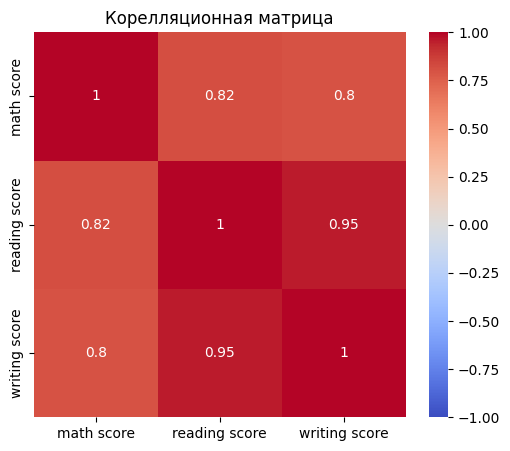

In [35]:
corr_matrix = df_scaled.corr('pearson')
print(corr_matrix)
plt.figure(figsize=(6, 5))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', vmin = -1, vmax = 1)
plt.title("Корелляционная матрица")
plt.show()

Все числовые признаки сильно положительно коррелируют друг с другом. Особенно высока корреляция между reading и writing, что указывает на сильную связь этих навыков.